<a href="https://colab.research.google.com/github/vimesh630/Stock-Price-Forecast-Prediction/blob/main/Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Library

In [18]:
# Import all required libraries
from google.colab import drive
import yfinance as yf
import pandas as pd
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import joblib

Mount Drive and Install Dependecies

In [19]:
# Mount Google Drive for saving files
drive.mount('/content/drive')

# Install yfinance (not pre-installed in Colab)
!pip install yfinance

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Download Historical Dataset

In [20]:
# Define stocks to predict
stocks = ["AAPL", "TSLA", "MSFT", "GOOGL", "AMZN", "NVDA"]

# Fetch 5 years of historical closing prices
data = {}
for stock in stocks:
    ticker = yf.Ticker(stock)
    data[stock] = ticker.history(period="5y")["Close"]

# Combine into a DataFrame with original dates
df = pd.DataFrame(data)

# Save raw dataset to Google Drive
df.to_csv("/content/drive/MyDrive/Individual_Projects/Stock_Price_Prediction/multi_stock_data_raw.csv")
print("Historical dataset downloaded and saved to Drive!")
df.head()

Historical dataset downloaded and saved to Drive!


,AAPL,TSLA,MSFT,GOOGL,AMZN,NVDA
Date,,,,,,
2020-03-18 00:00:00-04:00,59.861637,24.081333,134.387909,54.299896,91.500000,5.051888
2020-03-19 00:00:00-04:00,59.402969,28.509333,136.598969,55.319023,94.046501,5.304707
2020-03-20 00:00:00-04:00,55.631741,28.502001,131.468521,53.156361,92.304497,5.124869
2020-03-23 00:00:00-04:00,54.449886,28.952667,130.157181,52.455711,95.141502,5.297731
2020-03-24 00:00:00-04:00,59.912594,33.666668,141.987854,56.231659,97.004997,6.206632


Preprocess Dataset

In [21]:
# Load raw dataset (optional if restarting Colab)
df = pd.read_csv("/content/drive/MyDrive/Individual_Projects/Stock_Price_Prediction/multi_stock_data_raw.csv", index_col="Date", parse_dates=True)

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Fill missing values with forward fill (if any)
df.fillna(method="ffill", inplace=True)

# Add features: previous day's price and 7-day moving average
for stock in stocks:
    df[f"{stock}_Prev"] = df[stock].shift(1)  # Previous day's price
    df[f"{stock}_MA7"] = df[stock].rolling(window=7).mean()  # 7-day MA

# Drop rows with NaN from shifting/rolling
df.dropna(inplace=True)

# Save preprocessed dataset to Google Drive
df.to_csv("/content/drive/MyDrive/Individual_Projects/Stock_Price_Prediction/multi_stock_data_preprocessed.csv")
print("Dataset preprocessed and saved to Drive!")
df.head()

Missing values:
 AAPL     0
TSLA     0
MSFT     0
GOOGL    0
AMZN     0
NVDA     0
dtype: int64
Dataset preprocessed and saved to Drive!


<ipython-input-21-52645eac65c2>:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)


,AAPL,TSLA,MSFT,GOOGL,AMZN,NVDA,AAPL_Prev,AAPL_MA7,TSLA_Prev,TSLA_MA7,MSFT_Prev,MSFT_MA7,GOOGL_Prev,GOOGL_MA7,AMZN_Prev,AMZN_MA7,NVDA_Prev,NVDA_MA7
Date,,,,,,,,,,,,,,,,,,
2020-03-26 00:00:00-04:00,62.717976,35.210667,149.425156,57.869328,97.774498,6.407392,59.582546,58.794193,35.950001,30.696096,140.628677,137.807752,54.818916,54.878699,94.292000,94.580571,6.117959,5.644454
2020-03-27 00:00:00-04:00,60.121292,34.290668,143.289658,55.248863,95.004997,6.295057,62.717976,58.831286,35.210667,32.154572,149.425156,139.079431,57.869328,55.014266,97.774498,95.081285,6.407392,5.822050
2020-03-30 00:00:00-04:00,61.837036,33.475334,153.368729,57.042782,98.197502,6.615378,60.121292,59.179010,34.290668,32.864001,143.289658,141.475111,55.248863,55.260517,95.004997,95.674285,6.295057,6.009288
2020-03-31 00:00:00-04:00,61.710850,34.933334,150.956696,57.821060,97.486000,6.565810,61.837036,60.047454,33.475334,33.782763,153.368729,144.259136,57.042782,55.926903,98.197502,96.414500,6.615378,6.215137
2020-04-01 00:00:00-04:00,58.463810,32.104000,145.596481,54.842796,95.385002,6.054444,61.710850,60.620872,34.933334,34.232953,150.956696,146.464750,57.821060,56.267915,97.486000,96.449285,6.565810,6.323239


Update Data with Latest Prices

In [22]:
# Function to update data with the latest prices
def update_stock_data(df, stocks):
    new_data = {}
    for stock in stocks:
        ticker = yf.Ticker(stock)
        new_data[stock] = ticker.history(period="1d")["Close"]
        if not new_data[stock].empty:
            latest_date = new_data[stock].index[-1] # Get latest date as Timestamp object
            # latest_date = new_data[stock].index[-1].strftime('%Y-%m-%d') # Removed strftime conversion
            latest_price = new_data[stock].iloc[-1]
            if latest_date not in df.index:
                # Extend with previous row using correct index type
                df.loc[latest_date] = df.iloc[-1].values
            df.loc[latest_date, stock] = latest_price  # Update price
    return df

# Update with latest data
df = update_stock_data(df, stocks)
print("Data updated with latest prices:")
df.tail()

Data updated with latest prices:


,AAPL,TSLA,MSFT,GOOGL,AMZN,NVDA,AAPL_Prev,AAPL_MA7,TSLA_Prev,TSLA_MA7,MSFT_Prev,MSFT_MA7,GOOGL_Prev,GOOGL_MA7,AMZN_Prev,AMZN_MA7,NVDA_Prev,NVDA_MA7
Date,,,,,,,,,,,,,,,,,,
2025-03-12 00:00:00-04:00,216.979996,248.089996,383.269989,167.110001,198.889999,115.739998,220.839996,230.195714,230.580002,254.011433,380.450012,389.101427,164.039993,169.482295,196.589996,200.304284,108.750000,112.566883
2025-03-13 00:00:00-04:00,209.679993,240.679993,378.769989,162.759995,193.889999,115.580002,216.979996,226.445714,248.089996,249.531431,383.269989,387.695714,167.110001,168.344670,198.889999,198.888569,115.739998,112.509835
2025-03-14 00:00:00-04:00,213.490005,249.979996,388.559998,165.490005,197.949997,121.669998,209.679993,223.267142,240.679993,245.371429,378.769989,385.915715,162.759995,167.297389,193.889999,197.401426,115.580002,113.135662
2025-03-17 00:00:00-04:00,214.000000,238.009995,388.700012,164.289993,195.740005,119.529999,213.490005,220.219999,249.979996,241.737141,388.559998,384.745714,165.490005,166.174284,197.949997,196.692856,121.669998,114.417114
2025-03-18 00:00:00-04:00,212.695007,227.690002,382.660797,160.139999,192.020004,117.665001,214.000000,216.454285,238.009995,236.747140,388.700012,383.224400,164.289993,164.245712,195.740005,195.659999,119.529999,115.132880


Prepare Features for Real-Time Training

In [23]:
# Recalculate features after update
for stock in stocks:
    df[f"{stock}_Prev"] = df[stock].shift(1)  # Recalculate previous day's price
    df[f"{stock}_MA7"] = df[stock].rolling(window=7).mean()  # Recalculate 7-day MA

# Drop rows with NaN from shifting/rolling
df.dropna(inplace=True)

# Display prepared data
print("Data with updated features:")
df.tail()

Data with updated features:


,AAPL,TSLA,MSFT,GOOGL,AMZN,NVDA,AAPL_Prev,AAPL_MA7,TSLA_Prev,TSLA_MA7,MSFT_Prev,MSFT_MA7,GOOGL_Prev,GOOGL_MA7,AMZN_Prev,AMZN_MA7,NVDA_Prev,NVDA_MA7
Date,,,,,,,,,,,,,,,,,,
2025-03-12 00:00:00-04:00,216.979996,248.089996,383.269989,167.110001,198.889999,115.739998,220.839996,230.195714,230.580002,254.011433,380.450012,389.101427,164.039993,169.482295,196.589996,200.304284,108.750000,112.566883
2025-03-13 00:00:00-04:00,209.679993,240.679993,378.769989,162.759995,193.889999,115.580002,216.979996,226.445714,248.089996,249.531431,383.269989,387.695714,167.110001,168.344670,198.889999,198.888569,115.739998,112.509835
2025-03-14 00:00:00-04:00,213.490005,249.979996,388.559998,165.490005,197.949997,121.669998,209.679993,223.267142,240.679993,245.371429,378.769989,385.915715,162.759995,167.297389,193.889999,197.401426,115.580002,113.135662
2025-03-17 00:00:00-04:00,214.000000,238.009995,388.700012,164.289993,195.740005,119.529999,213.490005,220.219999,249.979996,241.737141,388.559998,384.745714,165.490005,166.174284,197.949997,196.692856,121.669998,114.417114
2025-03-18 00:00:00-04:00,212.695007,227.690002,382.660797,160.139999,192.020004,117.665001,214.000000,216.452142,238.009995,236.739997,388.700012,383.224400,164.289993,164.242855,195.740005,195.659999,119.529999,115.129308


Train the Model

In [24]:
# Define features (X) and targets (y)
feature_cols = [f"{stock}_Prev" for stock in stocks]  # e.g., ["AAPL_Prev", ..., "NVDA_Prev"]
X = df[feature_cols]
y = df[stocks]  # e.g., ["AAPL", ..., "NVDA"]

# Use all but the last row for training
X_train = X.iloc[:-1]
y_train = y.iloc[:-1]

# Train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

print("Model trained successfully!")

Model trained successfully!


Make Real-Time Predictions

In [25]:
# Use the last row for real-time prediction
X_latest = X.iloc[-1:]

# Predict on the latest data (real-time forecast)
latest_predictions = model.predict(X_latest)
print("Real-time forecast for next day:")
for stock, pred in zip(stocks, latest_predictions[0]):
    print(f"{stock}: ${pred:.2f}")

Real-time forecast for next day:
AAPL: $213.95
TSLA: $238.74
MSFT: $388.74
GOOGL: $164.12
AMZN: $195.71
NVDA: $119.55


Visualise Results

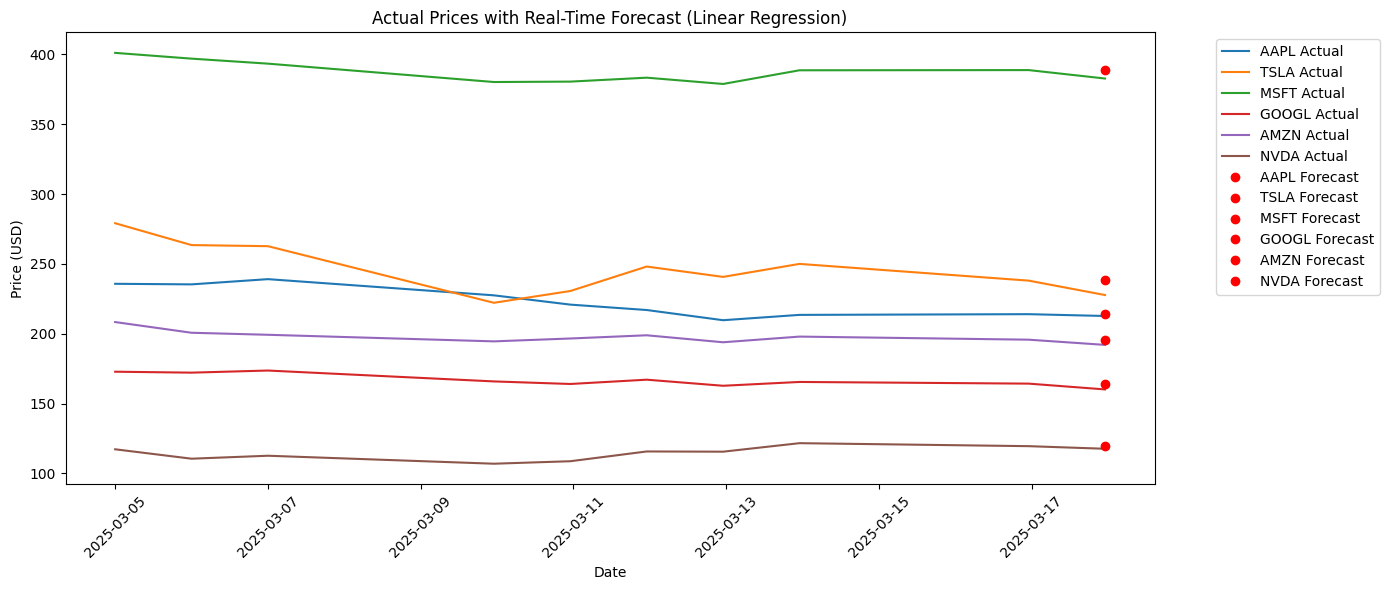

In [30]:
# Visualize actual prices with real-time forecast
plt.figure(figsize=(14, 6))
plt.plot(df.index[-10:], y.iloc[-10:], label=[f"{stock} Actual" for stock in stocks])  # Last 10 days

# Iterate over stocks and predictions to create individual forecast points
for i, stock in enumerate(stocks):
    plt.plot(df.index[-1], latest_predictions[0][i], 'ro', label=f"{stock} Forecast")

plt.title("Actual Prices with Real-Time Forecast (Linear Regression)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside to avoid clutter
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Save the Model

In [28]:
# Save the model to Google Drive for web application
model_save_path = "/content/drive/MyDrive/Individual_Projects/Stock_Price_Prediction/stock_model_realtime.pkl"
joblib.dump(model, model_save_path)
print(f"Model saved to {model_save_path} for web application!")

Model saved to /content/drive/MyDrive/Individual_Projects/Stock_Price_Prediction/stock_model_realtime.pkl for web application!
